In [1]:
import os
import tensorflow as tf

BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (299, 299)
SEED = 42

def extract_family_genus_and_species_from_path(path):
    # TensorFlow operation to extract the folder name from the full path
    parts = tf.strings.split(path, os.sep)
    folder_name = parts[
        -2
    ]  # Assumes the structure '/.../family_genus_species/image.jpg'

    # Split the folder name assuming the format "family_genus_species"
    family_genus_species = tf.strings.split(folder_name, "_")
    family = family_genus_species[-3]
    genus = family_genus_species[-2]
    species = family_genus_species[-2] + " " + family_genus_species[-1]

    return family, genus, species

def process_path(path, family_labels, genus_labels, species_labels):
    # Load the raw data from the file as a string
    img = tf.io.read_file(path)

    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image to the desired size
    img = tf.image.resize(img, [299, 299])

    # Get the family, genus, and species labels
    family, genus, species = extract_family_genus_and_species_from_path(path)

    # Convert family, genus, and species to indices
    family_label = tf.argmax(tf.equal(family_labels, family))
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))

    # Convert to one-hot encoded format
    family_label = tf.one_hot(family_label, len(family_labels))
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    # Return the image and a dictionary of labels with matching keys
    return img, {
        "family": family_label,
        "genus": genus_label,
        "species": species_label
    }

def build_dataset(directory, batch_size=32):
    # Get list of all files and extract labels
    file_paths = []
    family_labels = set()
    genus_labels = set()
    species_labels = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

                # Extract family, genus, and species
                folder_name = os.path.basename(os.path.dirname(file_path))
                family, genus, species = folder_name.split("_")

                species = genus + " " + species

                # Collect unique family, genus, and species names
                family_labels.add(family)
                genus_labels.add(genus)
                species_labels.add(species)

    # Convert sets to sorted lists to keep label indices consistent
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    # Create a TensorFlow dataset from the file paths
    path_ds = tf.data.Dataset.from_tensor_slices(file_paths)

    # Convert family, genus, and species labels to TensorFlow tensors
    family_labels = tf.constant(family_labels)
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(
        lambda x: process_path(x, family_labels, genus_labels, species_labels),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(file_paths))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return (
        image_label_ds,
        family_labels.numpy().tolist(),
        genus_labels.numpy().tolist(),
        species_labels.numpy().tolist(),
    )

# Usage
train_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/train"
)
val_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid"
)
test_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test"
)

2024-10-22 17:23:58.234079: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-22 17:23:58.234101: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-22 17:23:58.234105: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-22 17:23:58.234117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-22 17:23:58.234127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [3]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)

In [4]:
import matplotlib.pyplot as plt

#for image, _ in train_ds.take(1):
#  plt.figure(figsize=(10, 10))
#  first_image = image[0]
#  for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#    plt.imshow(augmented_image[0] / 255)
#    plt.axis('off')

In [8]:
# Image Preprocessing
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

base_model = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Define the inputs and apply augmentation
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Shared dense layer for better feature learning
shared_dense = tf.keras.layers.Dense(512, activation='relu')(x)

# Define family output
family_output = tf.keras.layers.Dense(len(family_labels), activation='softmax', name='family')(shared_dense)

# Concatenate the family output with the base model output
family_features = tf.keras.layers.Concatenate()([shared_dense, family_output])

# Define genus output, using family features as additional input
genus_hidden = tf.keras.layers.Dense(256, activation='relu')(family_features)
genus_output = tf.keras.layers.Dense(len(genus_labels), activation='softmax', name='genus')(genus_hidden)

# Concatenate the family and genus outputs with the base model output
genus_features = tf.keras.layers.Concatenate()([shared_dense, family_output, genus_output])

# Define species output, using both family and genus features as additional input
species_hidden = tf.keras.layers.Dense(256, activation='relu')(genus_features)
species_output = tf.keras.layers.Dense(len(species_labels), activation='softmax', name='species')(species_hidden)

# Create the hierarchical model
model = tf.keras.Model(inputs, [family_output, genus_output, species_output])


base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss={
        'family': 'categorical_crossentropy',
        'genus': 'categorical_crossentropy',
        'species': 'categorical_crossentropy'
    },
    metrics=['accuracy']
)

# %%
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 299, 299,  │          0 │ input_layer_4[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_1       │ (None, 299, 299,  │          0 │ sequential[1][0]  │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_1          │ (None, 299, 299,  │          0 │ true_divide_1[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 10, 10,    │ 23,564,800 │ subtract_1[0][0]  │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │  1,049,088 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 18)        │      9,234 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 530)       │          0 │ dense_3[0][0],    │
│ (Concatenate)       │                   │            │ family[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    135,936 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 45)        │     11,565 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 575)       │          0 │ dense_3[0][0],    │
│ (Concatenate)       │                   │            │ family[0][0],     │
│                     │                   │            │ genus[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    147,456 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 57)        │     14,649 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,932,728 (95.11 MB)

 Trainable params: 1,367,928 (5.22 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [9]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss={
        'family': 'categorical_crossentropy',
        'genus': 'categorical_crossentropy',
        'species': 'categorical_crossentropy'
    },
    metrics={
        'family': ['accuracy'],
        'genus': ['accuracy'],
        'species': ['accuracy']
    }
)

In [10]:
results = model.evaluate(test_ds)

print(f"Family Acc: {results[4]:.3f}")
print(f"Genus Acc: {results[5]:.3f}")
print(f"Species Acc: {results[6]:.3f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - family_accuracy: 0.0405 - family_loss: 3.0015 - genus_accuracy: 0.0289 - genus_loss: 3.9079 - loss: 11.0786 - species_accuracy: 0.0218 - species_loss: 4.1692
Family Acc: 0.046
Genus Acc: 0.029
Species Acc: 0.027


In [11]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 78s 401ms/step - family_accuracy: 0.3326 - family_loss: 2.2200 - genus_accuracy: 0.1546 - genus_loss: 3.4312 - loss: 9.3495 - species_accuracy: 0.1418 - species_loss: 3.6982 - val_family_accuracy: 0.6961 - val_family_loss: 1.1412 - val_genus_accuracy: 0.5656 - val_genus_loss: 1.9747 - val_loss: 5.4500 - val_species_accuracy: 0.4517 - val_species_loss: 2.3242
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 71s 392ms/step - family_accuracy: 0.6718 - family_loss: 1.1140 - genus_accuracy: 0.5493 - genus_loss: 1.8828 - loss: 5.1611 - species_accuracy: 0.4824 - species_loss: 2.1641 - val_family_accuracy: 0.7776 - val_family_loss: 0.7954 - val_genus_accuracy: 0.7175 - val_genus_loss: 1.1959 - val_loss: 3.4395 - val_species_accuracy: 0.6519 - val_species_loss: 1.4693
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 70s 386ms/step - family_accuracy: 0.7422 - family_loss: 0.8495 - genus_accuracy: 0.6850 - genus_loss: 1.2278 - loss: 3.5203 - species_accuracy: 0.6369 - speci

In [12]:
results = model.evaluate(test_ds)

print(f"Family Acc: {results[4]:.3f}")
print(f"Genus Acc: {results[5]:.3f}")
print(f"Species Acc: {results[6]:.3f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - family_accuracy: 0.8731 - family_loss: 0.4008 - genus_accuracy: 0.8555 - genus_loss: 0.5056 - loss: 1.4534 - species_accuracy: 0.8526 - species_loss: 0.5468
Family Acc: 0.886
Genus Acc: 0.864
Species Acc: 0.852


In [16]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [17]:
model.compile(
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
  loss="categorical_crossentropy", 
  metrics={
        'family': ['accuracy'],
        'genus': ['accuracy'],
        'species': ['accuracy']
    }
)

In [18]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=val_ds,
)

Epoch 11/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 110s 555ms/step - family_accuracy: 0.8223 - family_loss: 0.5715 - genus_accuracy: 0.8092 - genus_loss: 0.6866 - loss: 1.9916 - species_accuracy: 0.8052 - species_loss: 0.7335 - val_family_accuracy: 0.9081 - val_family_loss: 0.3127 - val_genus_accuracy: 0.8888 - val_genus_loss: 0.3994 - val_loss: 1.1682 - val_species_accuracy: 0.8722 - val_species_loss: 0.4515
Epoch 12/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 98s 544ms/step - family_accuracy: 0.8898 - family_loss: 0.3559 - genus_accuracy: 0.8896 - genus_loss: 0.3920 - loss: 1.1713 - species_accuracy: 0.8838 - species_loss: 0.4234 - val_family_accuracy: 0.9227 - val_family_loss: 0.2787 - val_genus_accuracy: 0.9006 - val_genus_loss: 0.3612 - val_loss: 1.0308 - val_species_accuracy: 0.8881 - val_species_loss: 0.4100
Epoch 13/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 97s 539ms/step - family_accuracy: 0.8993 - family_loss: 0.3064 - genus_accuracy: 0.9049 - genus_loss: 0.3279 - loss: 0.9953 - species_accuracy: 0.8958 - s

In [19]:
results = model.evaluate(test_ds)

print(f"Family Acc: {results[4]:.3f}")
print(f"Genus Acc: {results[5]:.3f}")
print(f"Species Acc: {results[6]:.3f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 268ms/step - family_accuracy: 0.9471 - family_loss: 0.1654 - genus_accuracy: 0.9287 - genus_loss: 0.2527 - loss: 0.6871 - species_accuracy: 0.9256 - species_loss: 0.2691
Family Acc: 0.954
Genus Acc: 0.933
Species Acc: 0.926


In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image_path, model, family_labels, genus_labels, species_labels, top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [299, 299])
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], [299, 299]) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


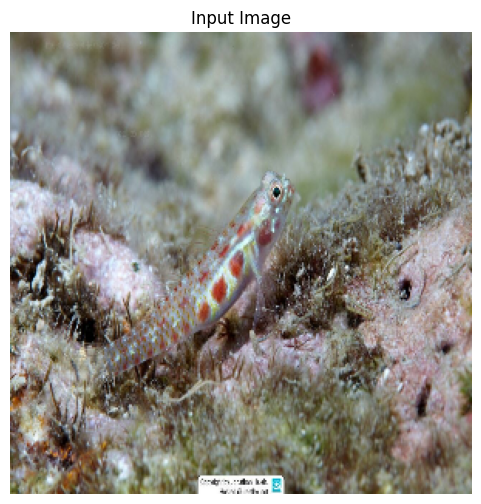

Top 3 Family Predictions:
b'Gobiidae': 0.9330
b'Tripterygiidae': 0.0361
b'Syngnathidae': 0.0239

Top 3 Genus Predictions:
b'Eviota': 0.8961
b'Corythoichthys': 0.0190
b'Fusigobius': 0.0154

Top 3 Species Predictions:
b'Eviota albolineata': 0.2619
b'Eviota atriventris': 0.1798
b'Corythoichthys flavofasciatus': 0.1189


In [15]:
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/66367_web_Eviota_melasma_6.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Trimma_macrophthalmus/21775_web_Trimma_macrophthalmus_32.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Istigobius_decoratus/21689_web_Istigobius_decoratus_441.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Istigobius_decoratus/86970_web_Istigobius_decoratus_496.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Trimma_macrophthalmus/65426378_fish_photo_10654.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/96590_web_Eviota_melasma_60.jpeg'


top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=3
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━

2024-10-22 18:35:27.212803: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


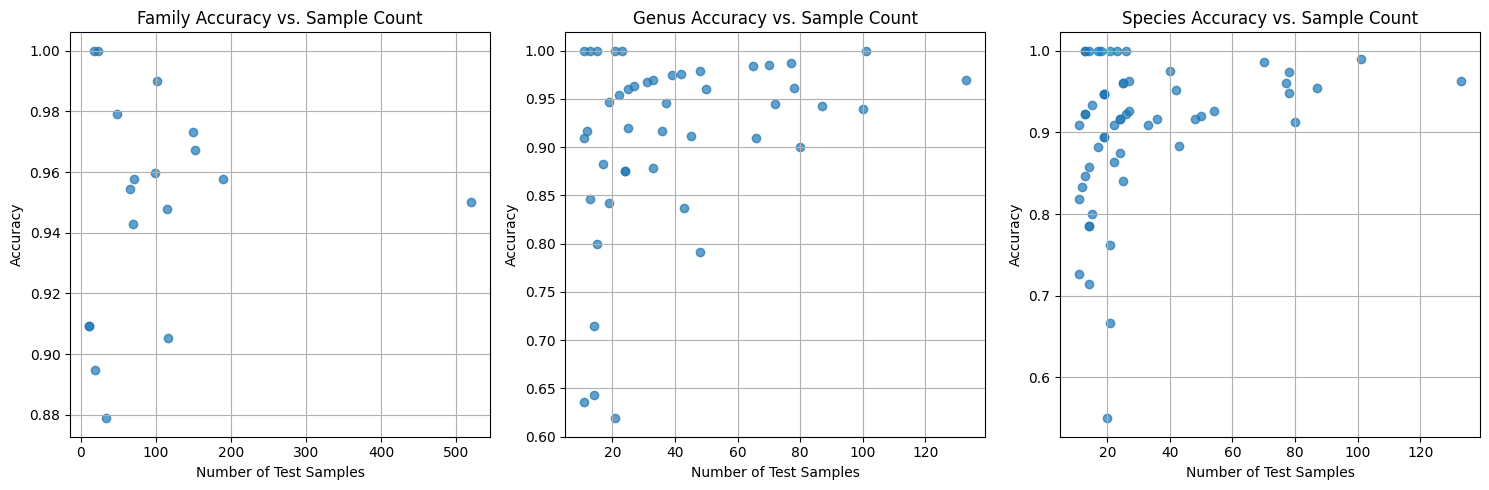

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def evaluate_accuracy_per_label(test_ds, model, family_labels, genus_labels, species_labels):
    # Initialize dictionaries to store correct predictions and counts for each label
    family_correct = defaultdict(int)
    genus_correct = defaultdict(int)
    species_correct = defaultdict(int)
    
    family_total = defaultdict(int)
    genus_total = defaultdict(int)
    species_total = defaultdict(int)

    # Iterate over the test dataset
    for images, labels in test_ds:
        # Get true labels
        true_family = tf.argmax(labels["family"], axis=1).numpy()
        true_genus = tf.argmax(labels["genus"], axis=1).numpy()
        true_species = tf.argmax(labels["species"], axis=1).numpy()

        # Get model predictions
        family_preds, genus_preds, species_preds = model.predict(images)
        pred_family = np.argmax(family_preds, axis=1)
        pred_genus = np.argmax(genus_preds, axis=1)
        pred_species = np.argmax(species_preds, axis=1)

        # Update counts for each label
        for true_fam, pred_fam, true_gen, pred_gen, true_spe, pred_spe in zip(
            true_family, pred_family, true_genus, pred_genus, true_species, pred_species
        ):
            # Update family counts
            family_total[true_fam] += 1
            if true_fam == pred_fam:
                family_correct[true_fam] += 1

            # Update genus counts
            genus_total[true_gen] += 1
            if true_gen == pred_gen:
                genus_correct[true_gen] += 1

            # Update species counts
            species_total[true_spe] += 1
            if true_spe == pred_spe:
                species_correct[true_spe] += 1

    # Calculate accuracy for each label
    family_accuracy = {family_labels[k]: family_correct[k] / family_total[k] for k in family_total if family_total[k] > 0}
    genus_accuracy = {genus_labels[k]: genus_correct[k] / genus_total[k] for k in genus_total if genus_total[k] > 0}
    species_accuracy = {species_labels[k]: species_correct[k] / species_total[k] for k in species_total if species_total[k] > 0}
    
    # Create dataframes for plotting
    family_df = pd.DataFrame({
        'Label': list(family_accuracy.keys()),
        'Accuracy': list(family_accuracy.values()),
        'Count': [family_total[family_labels.index(label)] for label in family_accuracy.keys()]
    })
    
    genus_df = pd.DataFrame({
        'Label': list(genus_accuracy.keys()),
        'Accuracy': list(genus_accuracy.values()),
        'Count': [genus_total[genus_labels.index(label)] for label in genus_accuracy.keys()]
    })
    
    species_df = pd.DataFrame({
        'Label': list(species_accuracy.keys()),
        'Accuracy': list(species_accuracy.values()),
        'Count': [species_total[species_labels.index(label)] for label in species_accuracy.keys()]
    })

    # Plot the correlations
    plt.figure(figsize=(15, 5))

    # Family plot
    plt.subplot(1, 3, 1)
    plt.scatter(family_df['Count'], family_df['Accuracy'], alpha=0.7)
    plt.title('Family Accuracy vs. Sample Count')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Genus plot
    plt.subplot(1, 3, 2)
    plt.scatter(genus_df['Count'], genus_df['Accuracy'], alpha=0.7)
    plt.title('Genus Accuracy vs. Sample Count')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Species plot
    plt.subplot(1, 3, 3)
    plt.scatter(species_df['Count'], species_df['Accuracy'], alpha=0.7)
    plt.title('Species Accuracy vs. Sample Count')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return family_df, genus_df, species_df

# Usage
family_df, genus_df, species_df = evaluate_accuracy_per_label(
    test_ds, model, family_labels, genus_labels, species_labels
)

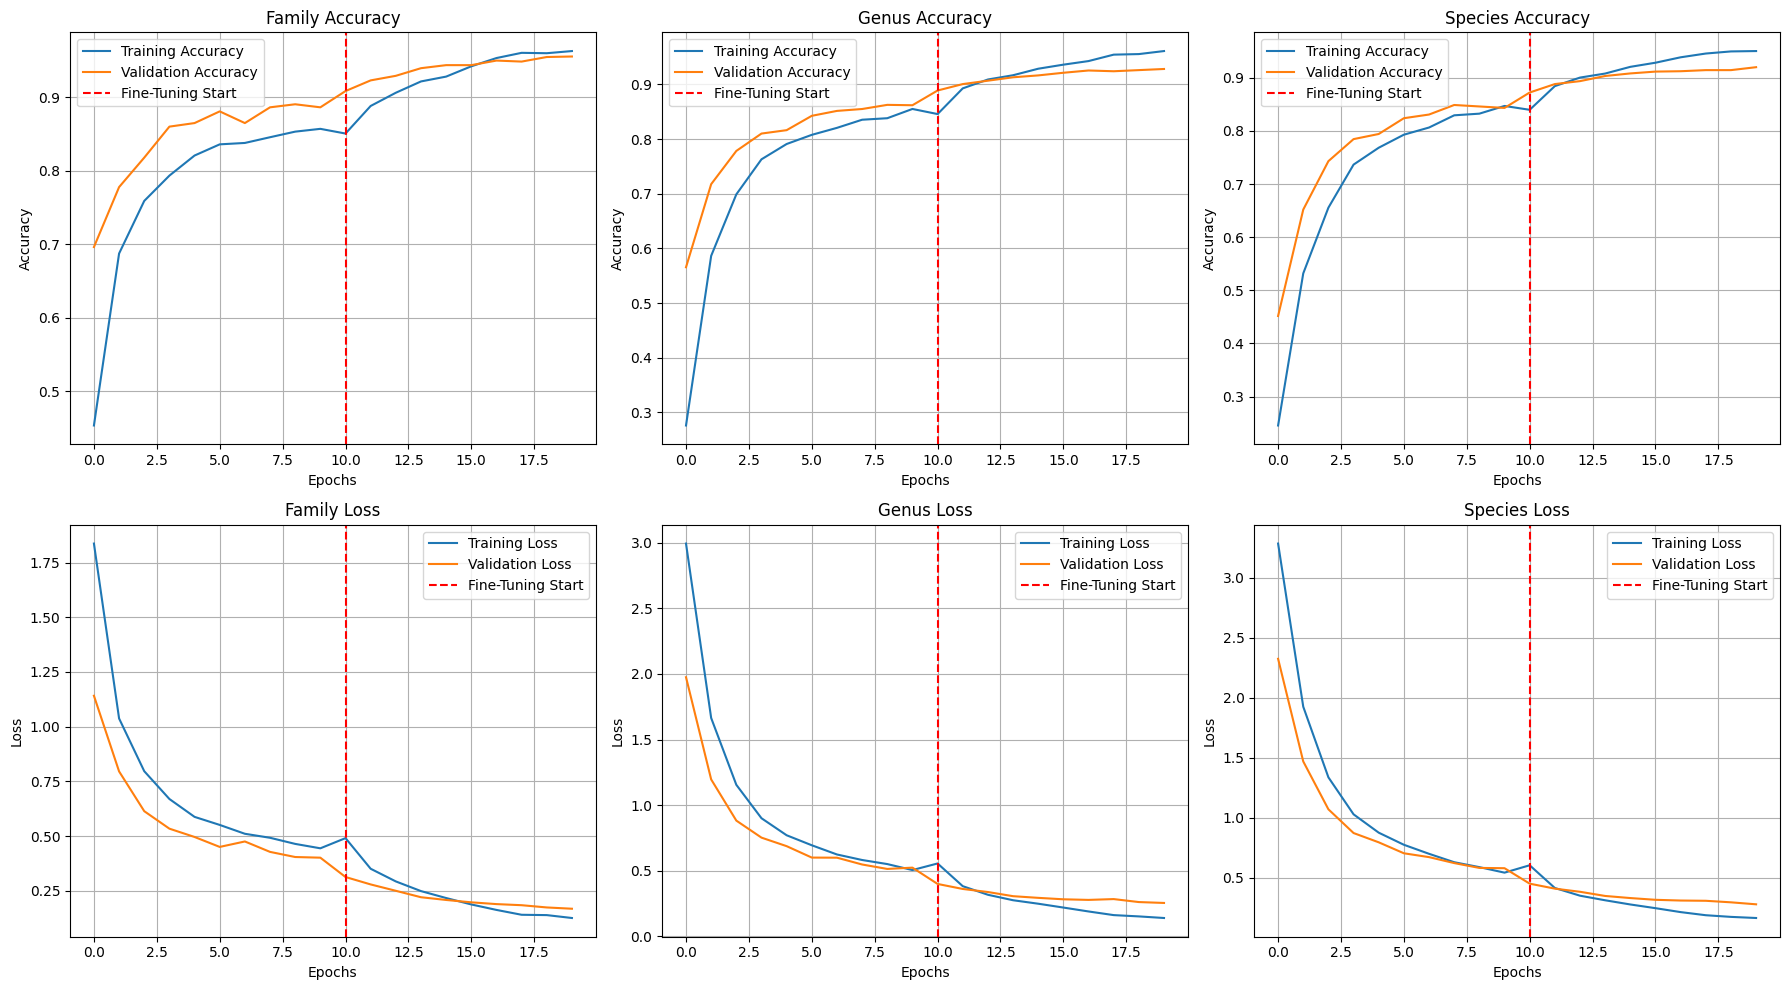

In [24]:
import matplotlib.pyplot as plt

def plot_training_history(history, history_fine, fine_tune_at):
    """
    Plot the training history of accuracy and loss for each output.
    
    Args:
    - history (History): History object from the initial training.
    - history_fine (History): History object from the fine-tuning phase.
    - fine_tune_at (int): Epoch at which fine-tuning began.
    """
    # Combine initial training history and fine-tuning history
    accuracy_keys = ['family_accuracy', 'genus_accuracy', 'species_accuracy']
    val_accuracy_keys = ['val_family_accuracy', 'val_genus_accuracy', 'val_species_accuracy']
    loss_keys = ['family_loss', 'genus_loss', 'species_loss']
    val_loss_keys = ['val_family_loss', 'val_genus_loss', 'val_species_loss']

    # Combine the data from the initial training and fine-tuning phases
    combined_history = {}
    for key in accuracy_keys + val_accuracy_keys + loss_keys + val_loss_keys:
        combined_history[key] = history.history.get(key, []) + history_fine.history.get(key, [])

    total_epochs = len(combined_history[accuracy_keys[0]])  # Total number of epochs including fine-tuning
    
    # Create subplots for accuracy and loss
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot accuracy for each output
    for idx, key in enumerate(accuracy_keys):
        axs[0, idx].plot(combined_history[key], label='Training Accuracy')
        axs[0, idx].plot(combined_history[val_accuracy_keys[idx]], label='Validation Accuracy')
        axs[0, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[0, idx].set_title(f'{key.replace("_accuracy", "").capitalize()} Accuracy')
        axs[0, idx].set_xlabel('Epochs')
        axs[0, idx].set_ylabel('Accuracy')
        axs[0, idx].legend()
        axs[0, idx].grid(True)
    
    # Plot loss for each output
    for idx, key in enumerate(loss_keys):
        axs[1, idx].plot(combined_history[key], label='Training Loss')
        axs[1, idx].plot(combined_history[val_loss_keys[idx]], label='Validation Loss')
        axs[1, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[1, idx].set_title(f'{key.replace("_loss", "").capitalize()} Loss')
        axs[1, idx].set_xlabel('Epochs')
        axs[1, idx].set_ylabel('Loss')
        axs[1, idx].legend()
        axs[1, idx].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# fine_tune_at = len(history.epoch)  # Get the epoch where fine-tuning started
plot_training_history(history, history_fine, fine_tune_at=10)

In [30]:
import os
import numpy as np
from collections import defaultdict
import pandas as pd
import tensorflow as tf

def get_taxonomic_mappings_from_folders(data_dir):
    """
    Extract family, genus, and species mappings from the dataset folder structure.
    
    Args:
    - data_dir (str): Path to the training dataset directory.
    
    Returns:
    - family_labels (list): List of unique family names.
    - genus_labels (list): List of unique genus names.
    - species_labels (list): List of unique species names.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    """
    family_labels = set()
    genus_labels = set()
    species_labels = set()
    genus_to_family = {}
    species_to_genus = {}

    # Iterate through the folders in the data directory
    for folder_name in os.listdir(data_dir):
        # Assume folder names are in the format "family_genus_species"
        parts = folder_name.split('_')
        if len(parts) == 3:
            family, genus, species = parts
            family_labels.add(family)
            genus_labels.add(genus)
            species_full = f"{genus}_{species}"
            species_labels.add(species_full)

            # Map genus to family
            genus_to_family[genus] = family

            # Map species to genus
            species_to_genus[species_full] = genus

    # Sort the labels to maintain consistent ordering
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    return family_labels, genus_labels, species_labels, genus_to_family, species_to_genus

def analyze_taxonomic_misclassifications(model, dataset, family_labels, genus_labels, species_labels, genus_to_family, species_to_genus):
    """
    Analyze misclassifications of a trained model to check if taxonomic hierarchies are respected.
    
    Args:
    - model (tf.keras.Model): The trained model.
    - dataset (tf.data.Dataset): Validation or test dataset.
    - family_labels, genus_labels, species_labels (list): List of class labels for family, genus, and species.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    
    Returns:
    - summary (dict): A dictionary containing summary of misclassifications.
    - genus_df (DataFrame): DataFrame with genus misclassification details.
    - species_df (DataFrame): DataFrame with species misclassification details.
    """
    # Counters for misclassifications
    genus_misclassifications = defaultdict(int)
    genus_respect_family = 0
    genus_total_mistakes = 0

    species_misclassifications = defaultdict(int)
    species_respect_genus = 0
    species_respect_family = 0
    species_total_mistakes = 0

    # Iterate over the dataset to collect predictions and true labels
    for images, labels in dataset:
        # Get the logits from the model for each output (family, genus, species)
        family_logits, genus_logits, species_logits = model(images, training=False)

        # Get true and predicted labels for each level
        true_family_indices = tf.argmax(labels['family'], axis=1).numpy()
        true_genus_indices = tf.argmax(labels['genus'], axis=1).numpy()
        true_species_indices = tf.argmax(labels['species'], axis=1).numpy()

        pred_family_indices = np.argmax(family_logits, axis=1)
        pred_genus_indices = np.argmax(genus_logits, axis=1)
        pred_species_indices = np.argmax(species_logits, axis=1)

        # Analyze genus misclassifications
        for true_genus_idx, pred_genus_idx in zip(true_genus_indices, pred_genus_indices):
            if true_genus_idx != pred_genus_idx:
                genus_total_mistakes += 1
                true_genus = genus_labels[true_genus_idx]
                pred_genus = genus_labels[pred_genus_idx]

                # Count the misclassification
                genus_misclassifications[(true_genus, pred_genus)] += 1

                # Check if the misclassified genus is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)  # Use .get() in case pred_genus is missing
                if true_family == pred_family:
                    genus_respect_family += 1

        # Analyze species misclassifications
        for true_species_idx, pred_species_idx in zip(true_species_indices, pred_species_indices):
            if true_species_idx != pred_species_idx:
                species_total_mistakes += 1
                true_species = species_labels[true_species_idx]
                pred_species = species_labels[pred_species_idx]

                # Count the misclassification
                species_misclassifications[(true_species, pred_species)] += 1

                # Check if the misclassified species is in the same genus
                true_genus = species_to_genus[true_species]
                pred_genus = species_to_genus.get(pred_species, None)
                if true_genus == pred_genus:
                    species_respect_genus += 1

                # Check if the misclassified species is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)
                if true_family == pred_family:
                    species_respect_family += 1

    # Calculate percentages of misclassifications that respect the hierarchy
    genus_hierarchy_respect_pct = (genus_respect_family / genus_total_mistakes) * 100 if genus_total_mistakes > 0 else 0
    species_hierarchy_respect_genus_pct = (species_respect_genus / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0
    species_hierarchy_respect_family_pct = (species_respect_family / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0

    # Create a summary of the analysis
    summary = {
        'genus_total_mistakes': genus_total_mistakes,
        'genus_hierarchy_respect': genus_respect_family,
        'genus_hierarchy_respect_pct': genus_hierarchy_respect_pct,
        'genus_misclassifications': dict(genus_misclassifications),
        'species_total_mistakes': species_total_mistakes,
        'species_hierarchy_respect_genus': species_respect_genus,
        'species_hierarchy_respect_genus_pct': species_hierarchy_respect_genus_pct,
        'species_hierarchy_respect_family': species_respect_family,
        'species_hierarchy_respect_family_pct': species_hierarchy_respect_family_pct,
        'species_misclassifications': dict(species_misclassifications),
    }

    # Convert misclassification dictionaries to DataFrames for better readability
    genus_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in genus_misclassifications.items()],
        columns=['True Genus', 'Predicted Genus', 'Count']
    ).sort_values(by='Count', ascending=False)

    species_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in species_misclassifications.items()],
        columns=['True Species', 'Predicted Species', 'Count']
    ).sort_values(by='Count', ascending=False)

    # Print the summaries
    print(f"Genus Misclassifications: {genus_total_mistakes}")
    print(f"Genus Misclassifications Respecting Family: {genus_respect_family} ({genus_hierarchy_respect_pct:.2f}%)")
    print(f"\nTop Genus Misclassifications:\n{genus_df.head(10)}")

    print(f"\nSpecies Misclassifications: {species_total_mistakes}")
    print(f"Species Misclassifications Respecting Genus: {species_respect_genus} ({species_hierarchy_respect_genus_pct:.2f}%)")
    print(f"Species Misclassifications Respecting Family: {species_respect_family} ({species_hierarchy_respect_family_pct:.2f}%)")
    print(f"\nTop Species Misclassifications:\n{species_df.head(10)}")

    return summary, genus_df, species_df

# Example usage:
# Assuming 'train_dir' is the path to the training dataset directory.
#train_dir = "/path/to/training_data"
family_labels, genus_labels, species_labels, genus_to_family, species_to_genus = get_taxonomic_mappings_from_folders(train_dir)

# Now analyze the misclassifications using the mappings
summary, genus_df, species_df = analyze_taxonomic_misclassifications(
    model=model,
    dataset=test_ds,
    family_labels=family_labels,
    genus_labels=genus_labels,
    species_labels=species_labels,
    genus_to_family=genus_to_family,
    species_to_genus=species_to_genus
)

Genus Misclassifications: 121
Genus Misclassifications Respecting Family: 44 (36.36%)

Top Genus Misclassifications:
        True Genus Predicted Genus  Count
4       Fusigobius      Istigobius      5
50     Cirripectes        Ecsenius      4
53      Istigobius      Fusigobius      3
25        Fowleria            Ucla      3
18  Enneapterygius            Ucla      3
44  Enneapterygius     Helcogramma      3
0      Cirripectes        Plesiops      2
13            Ucla  Corythoichthys      2
55  Corythoichthys  Enneapterygius      2
23        Fowleria       Priolepis      2

Species Misclassifications: 134
Species Misclassifications Respecting Genus: 15 (11.19%)
Species Misclassifications Respecting Family: 57 (42.54%)

Top Species Misclassifications:
               True Species           Predicted Species  Count
26           Eviota_melasma          Eviota_albolineata      4
55   Cirripectes_variolosus            Ecsenius_pulcher      4
38     Istigobius_decoratus        Fusigobius_neoph